In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform, pdist, cdist
plt.rcParams['figure.figsize']  = (6.0, 4.0)
plt.rcParams['figure.dpi'] = 72.0
from utils import *

In [3]:
from scipy.optimize import lsq_linear
def getPermutedTensor(factors, lambdas, tensorX, NDIRS):
    
    """Find the optimal circular-shifts used by the permuted decomposition to produce
    the tensor components, and apply it to the original tensor."""
    
    # Compute reconstructed tensor by scaling the first mode by the lambdas and 
    # multiplying by the kathri rao product of the other modes
    fittensor = np.reshape((lambdas * factors[0]) @ khatri_rao(factors[1:]).T, tensorX.shape)

    if NDIRS == 1: #no shifting possible, so simply return original tensor
        return tensorX, fittensor

    N = tensorX.shape[0]
    NSTIMS = tensorX.shape[1]
    RLEN = tensorX.shape[2]

    shape4d = (N,NSTIMS,NDIRS,RLEN//NDIRS)
    shapeDot = (N,RLEN)
    tensor4d = np.reshape(tensorX,shape4d,order='F')

    objs = np.empty((NSTIMS,N,NDIRS))
    obj_shifts = np.empty((NSTIMS,N))
    #find best shift (argmin) per stim for all cells at once
    for si in range(NSTIMS):
        for shifti in range(NDIRS):
            # cf. matlab code in `permuted-decomposition/matlab/my_tt_cp_fg.m`
            objs[si,:,shifti] = -np.sum(fittensor[:,si,:] * np.reshape(np.roll(tensor4d[:,si],shifti,1),shapeDot,order='F'), 1)
        obj_shifts[si] = np.argmin(objs[si],axis=1)

    #apply shifts
    shifted_tensor = np.zeros_like(tensorX)
    for shifti in range(NDIRS):
        rolledX = np.reshape(np.roll(tensor4d,shifti,2), tensorX.shape, order='F')
        for si in range(NSTIMS):
            shifted_tensor[(obj_shifts[si] == shifti),si,:] = rolledX[(obj_shifts[si] == shifti),si,:]

    #check that we get the same fit -- OK
    # normsqX = np.square(norm(tensorX.ravel()))
    # print((np.square(norm(shifted_tensor.ravel() - fittensor.ravel())))/( normsqX))
    # print('rec. error',preComputed[best_nfactors]['all_objs'][best_rep])
    return shifted_tensor, fittensor

def getNeuralMatrix(scld_permT, factors, lambdas, NDIRS, all_zeroed_stims=None,
                    order='F', verbose=True):
    """Computes the final neural matrix, X, by fitting the permuted tensor scaled by
    relative stimulus magnitudes using the factors obtained from NTF.
    
    Any previously zeroed out responses are now also permuted by the circular-shift
    producing the best fit.
    
    Additionally, a rebalancing of the factor magnitudes is applied to attribute
    a meaningful interpretation to the final coefficients.
    
    -------------------
    Arguments:
    
    scld_permT: ndarray, permuted tensor scaled by relative stimulus FRs
    
    factors: list, [neural_factors, stimulus_factors, response_factors] (normalized)
    
    lambdas: ndarray, shape (R,), where R is the number of components being used
    
    NDIRS: int, number of stimulus directions (rows in original 2D response maps)
    
    all_zeroed_stims: dict, {cell: (tuple of zeroed stim idxs)}, default None
    
    order: str, order used to flatten the original 2D response maps, default 'F' 
    
    -------------------
    Returns:
    X: ndarray, shape (Ncells, R), neural encoding matrix
    
    new_scld_permT: ndarray, tensor including previously zeroed out responses (if any)
    
    """

    R = lambdas.size
    
    #rebalance factor loadings based on relative stimulus contributions + scale by lambdas
    stim_factors = factors[1].copy()
    stim_scls = stim_factors.max(0,keepdims=1)
    stim_factors /= stim_scls

    neural_factors = factors[0].copy()
    neural_factors *= lambdas * stim_scls
    
    # rescaled stim x response coords
    new_coords = np.stack([khatri_rao([stim_factors[:,r][:,None],factors[2][:,r][:,None]]).ravel() for r in range(R)],axis=1)

    
    Ncells = scld_permT.shape[0]
    NSTIMS = scld_permT.shape[1]
    
    X = np.zeros((Ncells,R))
    
    new_scld_permT = scld_permT.copy()

    for c in range(Ncells):
        
        if verbose and (c+1) % 50 == 0: print(c+1,end=' ')

        if all_zeroed_stims is not None and c in all_zeroed_stims:
            # Any previously zeroed out responses are now also permuted by the circular-shift
            # producing the best fit.
            
            lowest_cost = np.inf
            #for each shift of all zeroed-stims together
            for shifti in range(NDIRS):
                shifted_cell_data = scld_permT[c].copy()

                for si in all_zeroed_stims[c]:
                    #rotate orig_data
                    si_2d = shifted_cell_data[si].reshape((NDIRS,-1),order=order)
                    shifted_cell_data[si] = np.roll(si_2d,shifti,axis=0).ravel(order=order)

                #compute fit cost
                res = lsq_linear(new_coords,shifted_cell_data.ravel(),bounds=(0,np.inf))
                coeffs, cost = res['x'], res['cost']

                #if lower reconstruction cost, update best shift combo
                if cost < lowest_cost:
                    lowest_cost = cost
                    best_shift = shifti
                    best_coeffs = coeffs
                    best_partial = True
                    new_scld_permT[c] = shifted_cell_data

            new_coeffs = best_coeffs

                
        else:#if no zeroed stims
            # update coefficients to fit our stimulus-rescaled tensor
            new_coeffs = lsq_linear(new_coords,scld_permT[c].ravel(),bounds=(0,np.inf))['x']

        # sqrt so that, for each stimulus, the magnitude of a vector of coeffs for factors
        # representing that stimulus can be at most 1, even if that stimulus response 
        # is split across multiple factors. This ultimately leads to better distances
        # between neurons
        X[c] = np.sqrt(new_coeffs)

    return X, new_scld_permT

#### tensor

In [4]:
#load activity data

basedir = '../../../deepnets/temp-tensors'
# set the filename used when saving the tensor4d with activations and neurons used
PREFIX = 'res50_shifted_act_i3_n2000_w26_SCL0_5_TL37_res3_maxFr_maxNr_fMag_imMax'
          

tensor4d = np.load(f'{basedir}/{PREFIX}/tensor4d_{PREFIX}.npy')
neurons_used = np.load(f'{basedir}/{PREFIX}/neurons_used_{PREFIX}.npy')

tensor4d.shape

(2000, 11, 8, 37)

### create tensor

In [5]:
def from0to1(arr):
    arr = np.asanyarray(arr)
    arr[np.isclose(arr,0)] = 1
    return arr
N, NSTIMS, NDIRS, TRIAL_LEN = tensor4d.shape

method = 'relNorm' # simplification for CNNs -- since there is no notion of statistical significance of spike rates,
                    # assume all are significant (since very low responses won't even be sampled), so pre-scale the responses
                    # by their relative FRs
        
smooth_sig = 3 ##how many frames in 50 ms (max smoothing window used for biological neurons)? #0.050/(1/60) == 3


from scipy.ndimage import gaussian_filter1d


optSF = True # use the optimal spatial frequency (SF) across stimulus classes
SF_med_idxs = [0,2,5,6,9,10] # idxs of medium SF stims plus LF Gratings (0)
SF_hi_idxs = [0,1,3,4,7,8] #high SF plus LF Gratings (0)
if optSF:
    optStims = []
    tensorX = np.zeros((N,NSTIMS//2+1,NDIRS * TRIAL_LEN))
    relFRs = np.zeros((N,NSTIMS//2+1))
else:
    tensorX = np.zeros((N,NSTIMS,NDIRS * TRIAL_LEN))
    relFRs = np.zeros((N,NSTIMS))

# Collect psts for those sampled neurons
for nii in range(tensor4d.shape[0]):
    

    relMeanPosFRs = []
    all_psts = np.zeros((NSTIMS,NDIRS * TRIAL_LEN))
    for stimi in range(NSTIMS):
        
        pst = tensor4d[nii,stimi]
        
        if smooth_sig > 0:
            pst = gaussian_filter1d(pst,smooth_sig,axis=1)
                
        relMeanPosFRs.append(max(pst.mean(1)))
        all_psts[stimi] = pst.ravel(order='F')
        
    relMeanPosFRs = np.array(relMeanPosFRs)

    if optSF:
        #choose optimal SF
        med_FRs = relMeanPosFRs[SF_med_idxs]
        hi_FRs = relMeanPosFRs[SF_hi_idxs]
        if (med_FRs > hi_FRs).sum() > (hi_FRs > med_FRs).sum():
            relMeanPosFRs = med_FRs
            tensorX[nii] = all_psts[SF_med_idxs]
            optStims.append('med')
        else:
            relMeanPosFRs = hi_FRs
            tensorX[nii] = all_psts[SF_hi_idxs]
            optStims.append('hi')
            
    relFRs[nii] = relMeanPosFRs/max(relMeanPosFRs)

    if method == 'relFR':
        tensorX[nii] /= tensorX[nii].max()
        
    elif method == 'relNorm':#make each pst unit norm, then rescale according to relative FR
        stim_norms = from0to1(np.linalg.norm(tensorX[nii],axis=1,keepdims=1))
        tensorX[nii] /= from0to1(stim_norms)
        tensorX[nii] *= relFRs[nii][:,None]
        
PREFIX2 = f'{method}_sig{smooth_sig}_n{N}'
if optSF:
    PREFIX2 += '_SF'
tensorX.shape

(2000, 6, 296)

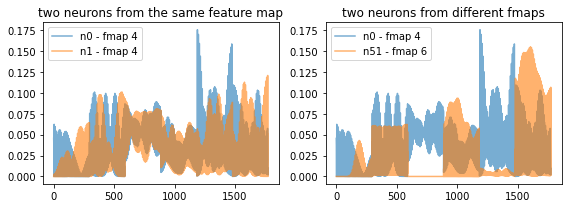

In [5]:
# examples of 1-d "flattened" psths (concatenated for all directions and all stimuli) from 2 different neurons
# for a rough comparison of how different they look

f, axes = plt.subplots(1, 2, figsize=(8,3))

ax = axes[0]
ni, nj = 0, 1
for n_ in [ni,nj]:
    ax.plot(tensorX[n_].ravel('C'), alpha=.6, label=f'n{n_} - fmap {neurons_used[n_,0]}')
ax.legend()
ax.set_title('two neurons from the same feature map')

ax = axes[1]
ni, nj = 0, np.flatnonzero(neurons_used[:,0] != neurons_used[0,0])[1]
for n_ in [ni,nj]:
    ax.plot(tensorX[n_].ravel('C'), alpha=.6, label=f'n{n_} - fmap {neurons_used[n_,0]}')
ax.legend()
ax.set_title('two neurons from different fmaps')

f.tight_layout()
plt.show()

Positions of neurons sampled from each layer/feature map within the block


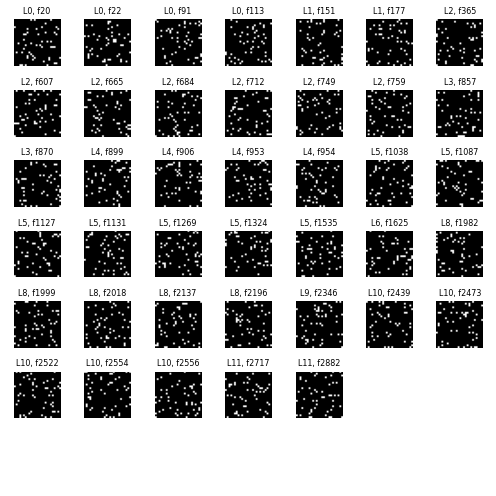

In [83]:
# Show (in space) which units were sampled from which feature maps in that layer
fmap_side = neurons_used[:,[2,3]].max() + 1

layer_mask = neurons_used[:,0] == layer_i

fmaps_used = np.unique(neurons_used[:,1])
nfmaps = fmaps_used.size

#for each factor

#create square grid of subplots
grid_side = int(np.ceil(np.sqrt(nfmaps)))
f,axes = plt.subplots(grid_side,grid_side,figsize=(grid_side,grid_side))
f.subplots_adjust(hspace=.3)
if grid_side == 1:
    axes = [[axes]]

canvas = np.zeros((nfmaps, fmap_side, fmap_side))
for fi in range(nfmaps):
    #create sq array representing the feature map, showing which neurons were sampled from it
    fmap_nis = np.flatnonzero([neurons_used[:,1] == fmaps_used[fi]]) #idxs of all neurons from fmap fi
    canvas[([fi]*len(fmap_nis), neurons_used[fmap_nis,2], neurons_used[fmap_nis,3])] = 1 #set neurons' positions to 1

for fi in range(grid_side**2):

    ax = axes[fi//grid_side][fi%grid_side]
    ax.axis('off')
    if fi >= nfmaps: continue
        
    #fmap/layer it came from
    fmap_i = fmaps_used[fi]
    layer_i = neurons_used[np.flatnonzero(neurons_used[:,1] == fmap_i)[0], 0]


    ax.imshow(canvas[fi], cmap='binary_r')
    ax.set_title(f'L{layer_i}, f{fmap_i}', size=8)

f.tight_layout()
print('Positions of neurons sampled from each layer/feature map within the block')
plt.show()            


### compute CP

In [155]:
CPMETHOD = 'shift'
AREA = 'deepnet'
tensorname = '%s-%s-%s-%s' % (PREFIX,PREFIX2,AREA,CPMETHOD)
print(tensorname)

res50_shifted_act_i3_n2000_w26_SCL0_5_TL37_res3_maxFr_maxNr_fMag_imMax-relNorm_sig3_n2000_SF-deepnet-shift


In [154]:
# save tensor as .mat file
from scipy.io import savemat

tfname = f'{basedir}/{tensorname}.mat'

savemat(tfname,{'X':mytensor})

# run run_permcp.m on Matlab using the following parameters:
# nreps = 30
# NDIRS = 8
# minrank,maxrank,rankstep = 2,30,1 #inclusive

### load factors

In [42]:
def loadPreComputed(tensorname,basedir,specificRanks=[],computeSimis=False,NMODES=3,verbose=True,
    specificReps=[]):
    
    if verbose:
        print('Loading',tensorname)

    

    preComputed = {}

    
    def parseRank(s):
        if s[-4:] == '.mat':
            extn = 4
        elif s[-2:] == '.p':
            extn = 2
        else:
            raise ValueError
        rank_str = s[:-extn].split('_rank')[-1]
        if '_r0_' in rank_str:
            rank_str, rep_str = rank_str.split('_r0_')
            return int(rank_str), int(rep_str)
        else:
            return int(rank_str), 1    
    if 'gauss' in tensorname or 'rayleigh' in tensorname or 'shift' in tensorname or 'orth' in tensorname:
        assert 'als' not in tensorname and 'bcd' not in tensorname and 'shashua' not in tensorname
        query = '%s/%s-cp/*rank*.mat' % (basedir,tensorname)
    else:
        assert 'als' in tensorname or 'bcd' in tensorname or 'shashua' in tensorname
        query = '%s/%s-cp/*rank*.p' % (basedir,tensorname)

#     print(query)
    queryfiles = glob(query)
    
    if '.mat' in query:
        queryfiles  += glob(query.replace('.mat','.p'))

    rank_ = None
    counted_reps = 0
    for r in sorted(queryfiles):
        
        rank, rep0 = parseRank(r)

        if specificRanks and rank not in specificRanks:
            continue
        if specificReps and rep0 not in specificReps:
            continue

        if rank != rank_:
            if int(verbose) > 1:
                print()
            elif int(verbose) == 1 and counted_reps > 0:
                print(f'({counted_reps})',end=' ')
            counted_reps = 0
            
            if verbose: print(f'R{rank}:',end=' ')
            rank_ = rank
        counted_reps += 1
        #rankfnames[rank] = r
        if int(verbose) > 1:
            print(f'.{rep0}',end='')
        
        if '.mat' in r:
            matfile = loadmat(r)
            try:
                assert matfile['factors'][0,0].shape[1] == NMODES
            except:
                print(matfile['factors'][0,0].shape)
                assert matfile['factors'][0,0].shape[1] == NMODES

            nreps = len(matfile['factors'][0])

            factors = {rep0+rep:matfile['factors'][0][rep].squeeze() for rep in range(nreps)}
            lambdas = {rep0+rep:matfile['lams'][0][rep].squeeze() for rep in range(nreps)}
            fits = {rep0+rep:matfile['fits'][0][rep].squeeze() for rep in range(nreps)}
            objs = {rep0+rep:matfile['objs'][0][rep].squeeze() for rep in range(nreps)}

            if computeSimis:
                raise NotImplementedError
                # if rep0 == 1:
                #     #compute simis
                #     U = KTensor(all_factors[rank][0])
                #     simis = {1:1.}

                #     for rep in range(1,len(all_factors[rank])):
                #         if computeSimis:
                #             V = KTensor(all_factors[rank][rep].squeeze())
                #             sim = kruskal_align(U, V, permute_V=True)
                #         else:
                #             sim = None
                #         simis[rep0+rep] = sim
            else:
                simis = {}

            #save data as pickle file
            rank_precomp = {'all_factors':factors,'all_lambdas':lambdas,
                            'all_objs':objs,'all_fits':fits,'all_simis':simis}

            with open(r.replace('.mat','.p'),'wb') as f: pickle.dump(rank_precomp,f)
            #delete .mat file
            os.remove(r)

        
        else:

            with open(r,'rb') as f:
                rank_precomp = pickle.load(f)

            assert len(rank_precomp['all_factors'][rep0]) == NMODES

            if type(rank_precomp['all_factors']) == list:
                assert 'all_lambdas' not in rank_precomp

                nreps = len(rank_precomp['all_factors'])
                factors = {rep0+rep:rank_precomp['all_factors'][rep] for rep in range(nreps)}
                lambdas = {rep0+rep:rank_precomp['factor_lams'][rep] for rep in range(nreps)}
                objs = {rep0+rep:rank_precomp['all_objs'][rep] for rep in range(nreps)}
                simis = {rep0+rep:rank_precomp['all_simis'][rep] for rep in range(nreps)}
                if 'all_fits' in rank_precomp:
                    fits = {rep0+rep:rank_precomp['all_fits'][rep] for rep in range(nreps)}
                else:
                    fits = {}

                rank_precomp = {'all_factors':factors,'all_lambdas':lambdas,
                                'all_objs':objs,'all_fits':fits,'all_simis':simis}
        
        if rank not in preComputed:
            preComputed[rank] = rank_precomp.copy()

        else:#merge results
            for dkey in rank_precomp.keys():
                preComputed[rank][dkey].update(rank_precomp[dkey])

    if int(verbose) == 1 and counted_reps > 0:
        print(f'({counted_reps})')
    ranks = sorted(preComputed.keys())
    return preComputed,ranks

In [43]:
# tensorname = 'base-tensor-name'#input tensor base filename
resultsdir = f'{basedir}/{PREFIX}' #where to find the .mat files produced by the permuted tensor decomposition
#each .mat file should have the format: "{base-tensor-name}_rank_{# factors chosen}"
preComputed,Fs = loadPreComputed(tensorname,resultsdir,verbose=False)


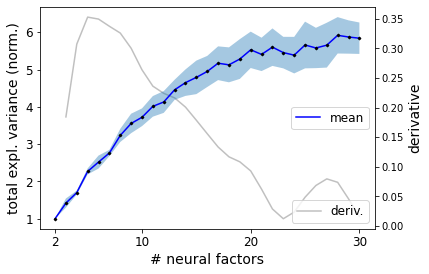

In [19]:
#plot total normalized explained variance (nuclear norm) for each F

nfacs = np.array(Fs)
NEURALMODE = 0
mus = []

stds = []

LGD_SZ = 12
LBL_SZ = 14
TICK_SZ = 12

for nf in nfacs:
    #collect factors for all available repetitions
    neuralfs = np.array([preComputed[nf]['all_factors'][repi][NEURALMODE] for repi in sorted(preComputed[nf]['all_factors'])])
    #normalize
    neuralfs = [f/from0to1(np.linalg.norm(f,axis=0,keepdims=1)) for f in neuralfs]
    
    nucl_norms = []
    
    reps_used = list(preComputed[nf]['all_lambdas'])###
    
    for repi in range(len(preComputed[nf]['all_factors'])):

        A = neuralfs[repi].copy()
        Si = A.T
        Si -= Si.mean(0)
        #compute explained variances
        s = np.linalg.svd(Si,full_matrices=False,compute_uv=False)
        var = s**2/(Si.shape[0]-1)   
        #normalize
        var /= var.max()
        # compute nuclear norm (sum of eigenvals)
        nucl_norms.append( var.sum() )

    mus.append(np.mean(nucl_norms))
    stds.append(np.std(nucl_norms))

f,ax1 = subps(1,1,4,6)
ax1.plot(nfacs, mus,'b-', label='mean')
ax1.plot(nfacs, mus,'kD',markersize=2)

mus = np.array(mus)
grads = np.diff(gaussian_filter1d(mus,1.5))
ax1_ = ax1.twinx()
ax1_.plot(nfacs[1:],grads,c='silver',label='deriv.',zorder=0)
ax1_.set_ylabel('derivative',size=LBL_SZ)
ax1_.legend(loc="lower right",fontsize=LGD_SZ)
stds = np.array(stds)
ax1.fill_between(nfacs,mus-stds,mus+stds,alpha=.4)
ax1.set_xlabel('# neural factors',size=LBL_SZ)
ax1.set_ylabel('total expl. variance (norm.)',size=LBL_SZ)
ax1.set_xticks([2]+list(range(10,31,10)))
ax1.tick_params(labelsize=TICK_SZ)
ax1.legend(loc="center right",fontsize=LGD_SZ)
ax1.set_zorder(ax1_.get_zorder()+1)
ax1.set_frame_on(False)

plt.show()

In [137]:
R = 12
rep, error = min(preComputed[R]['all_objs'].items(), key=lambda x: x[1])
print(f'The repetition with min error was #{rep} (% error = {error:.3f})')

The repetition with min error was #14 (% error = 9.711)


In [138]:
best_rep = 14
best_factors = preComputed[R]['all_factors'][best_rep]
best_lambdas = preComputed[R]['all_lambdas'][best_rep]
np.save(f'cp-files/{tensorname}_R{R}_factors.npy', best_factors)
np.save(f'cp-files/{tensorname}_R{R}_lambdas.npy', best_lambdas)

### show factors

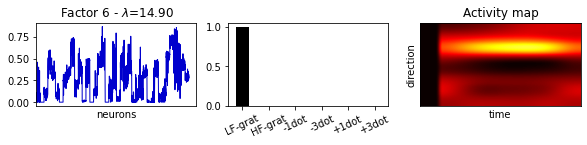

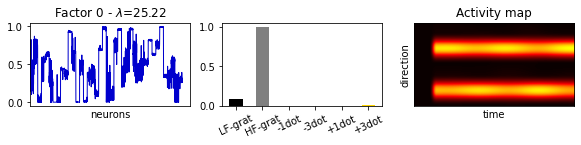

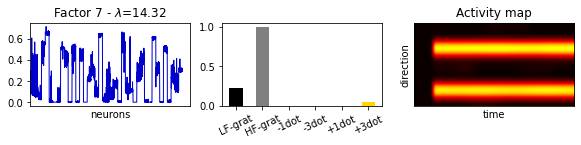

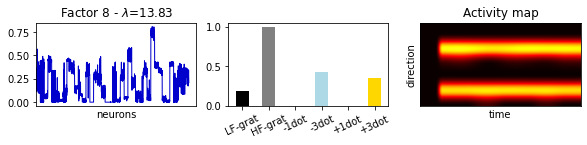

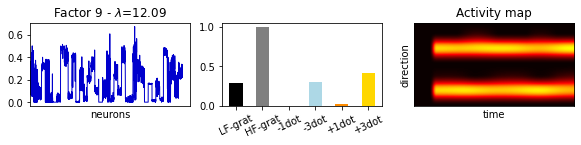

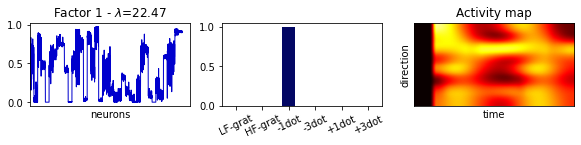

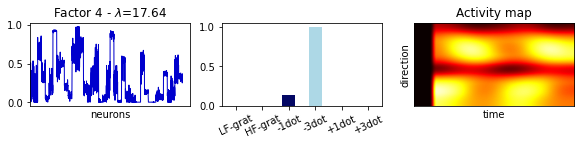

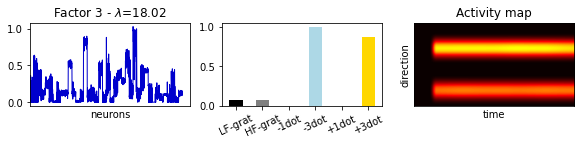

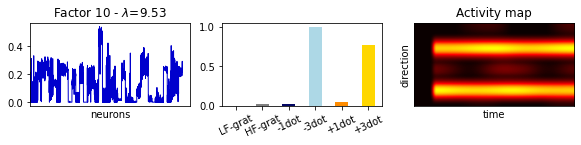

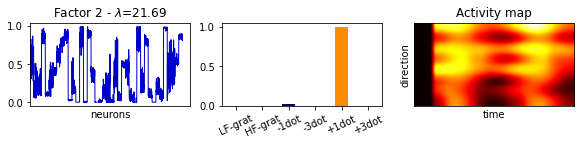

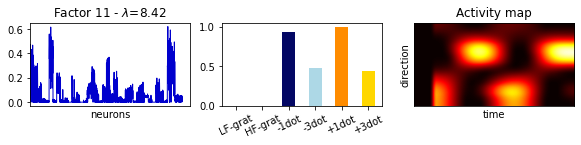

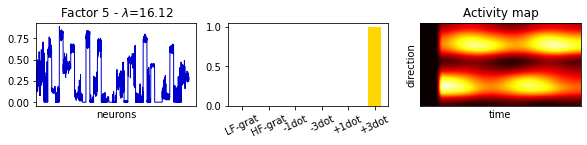

In [139]:
#PLOT FACTORS

R = 12 # got this from the analysis of the tensor components 
best_factors = np.load(f'cp-files/{tensorname}_R{R}_factors.npy',allow_pickle=True)
best_lambdas = np.load(f'cp-files/{tensorname}_R{R}_lambdas.npy',allow_pickle=True)


posnorms = ~np.isclose(best_lambdas,0)
best_lambdas = best_lambdas[posnorms]
nfactors = [f[:,posnorms]/np.linalg.norm(f[:,posnorms],axis=0,keepdims=1) for f in best_factors]



my_stims = ['LF-grat', 'HF-grat', '-1dot', '-3dot', '+1dot', '+3dot']

NSTIMS = len(my_stims)
NDIRS = 8

leaves = range(nfactors[0].shape[0])

colors = ['k','gray','xkcd:darkblue','lightblue','darkorange','gold']
assert len(colors) >= NSTIMS

ncols = 3; colsz = 3.25
nrows = R; rowsz = 1.5

#sort factors by predominant stim (%)
sorted_factors = np.argsort((nfactors[1]).argmax(axis=0))
#sorted_factors = range(best_nfactors)

#rebalance factor loadings, scale by lambdas
stim_factors = nfactors[1].copy()
stim_scls = stim_factors.max(0,keepdims=1)
stim_factors /= stim_scls

neural_factors = nfactors[0].copy()
neural_factors *= best_lambdas
neural_factors *= stim_scls

for ll,l in enumerate(sorted_factors):
    
    fig,axes = plt.subplots(1,ncols,figsize=(colsz*ncols,rowsz))

    ax = axes[0]
    ax.set_title(r'Factor %d - $\lambda$=%.2f' % (l,best_lambdas[l]))
    ax.plot(neural_factors[leaves,l],lw=1,c='mediumblue')
    ax.set_xlim(0,ax.get_xlim()[1])
    ax.set_xticks([])
    ax.set_xlabel('neurons')
    
    ax = axes[1]
    ax.bar(range(NSTIMS),stim_factors[:,l],width=.5,
            color=colors,tick_label=my_stims)

    ax.tick_params(axis='x', labelrotation=25)

    ax = axes[2]
    pst = nfactors[2][:,l].reshape(NDIRS,-1,order='F')
    # circular-shift response map to opt dir (for better visualization)
    opt_dir = pst.mean(1).argmax()
    pst = np.roll(pst,(2-opt_dir)%NDIRS,0)
    pst -= pst.min()
    # cosmetics: pad with zeros to mimic a "pre stimulus interval" when visualizing PSTHs
    pst = np.concatenate([np.zeros((NDIRS,5)),pst],axis=1)  
    ax.imshow(pst,aspect='auto',interpolation='quadric',cmap='hot')
    ax.set_title('Activity map')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel('direction'); ax.set_xlabel('time')
    plt.show()

### load CP decomposition, compute neural matrix

In [140]:
# Load pre-computed optimal factors and corresponding lambdas

R = 12 # got this from the analysis of the tensor components
best_factors = np.load(f'cp-files/{tensorname}_R{R}_factors.npy',allow_pickle=True)
best_lambdas = np.load(f'cp-files/{tensorname}_R{R}_lambdas.npy',allow_pickle=True)

# remove any eventual zero-norm factor
posnorms = ~np.isclose(best_lambdas,0)
lambdas = best_lambdas[posnorms]
# make sure they are all normalized
factors = [f[:,posnorms]/np.linalg.norm(f[:,posnorms],axis=0,keepdims=1) for f in best_factors]

# find the permuted version of sigT that gave rise to the factors -- this is
# necessary for computing the actual rec error
sigT = tensorX
permT, fitT = getPermutedTensor(factors, lambdas, sigT, NDIRS)

all_zeroed_stims = None
scld_permT = permT #simplified for CNNs, since tensor was pre-scaled by FRs (see above)

X, all_scld_permT = getNeuralMatrix(
    scld_permT, factors, lambdas, NDIRS, all_zeroed_stims, order='F', verbose=False)


nPCs=np.int64(6)


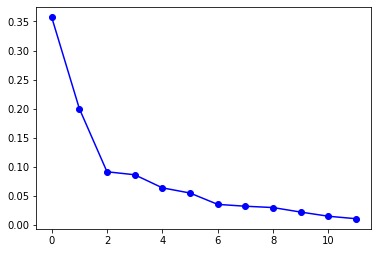

In [141]:
# optionally, eliminate possible redundancy among factors in the neural matrix using PCA
# (this is mostly used to ensure a more fair comparison across brain areas / networks, since they might use
# different numbers of tensor components)
from sklearn.decomposition import PCA
MIN_EXPL_VAR_RATIO = 0.8

pca = PCA(len(lambdas))
pcaX = pca.fit_transform(X)

# number of PCs can be chosen based on a prespecified explained variance ratio,
nPCs = np.flatnonzero(np.cumsum(pca.explained_variance_ratio_) > MIN_EXPL_VAR_RATIO)[0] + 1
print(f'{nPCs=}')

# or simply by inspection of the variance spectrum
plt.plot(pca.explained_variance_ratio_, 'bo-')
# nPCs = 

X = pcaX[:,:nPCs]

### compute distance matrix and check for outliers

In [142]:

from ian.ian import * #https://github.com/dyballa/IAN/
from ian.embed_utils import *
from ian.dset_utils import *
from ian.utils import *

# compute matrix of squared distances
D2 = pwdists(X, sqdists=True)
N = D2.shape[0]

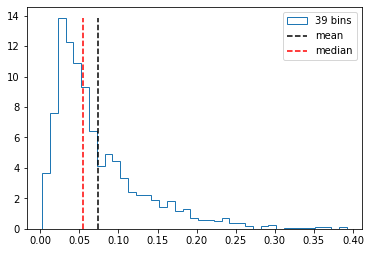

In [143]:
# especially for CNNs, it's a good idea to remove any obvious outliers before running IAN
nonoutliers = np.arange(D2.shape[0])
# this histogram of distance to nearest nbrs helps identifying them (if present)
# wanna remove points that have either this 1-NN distance too close to 0 (e.g. two neurons that had near zero response to everything)
# or neurons that were too different than everything else

D1 = np.sqrt(D2)
mindists = np.min(D1 + np.eye(N)*D1.max(),axis=0)
meanmind = mindists.mean()
medianmind = np.median(mindists)
#https://www.statisticshowto.com/choose-bin-sizes-statistics/
for n_bins in ['fd']:#,'doane','stone']:
    if type(n_bins) is str:
        try:
            bin_edges = np.histogram_bin_edges(mindists,n_bins)
        except:
            continue
        n_bins = len(bin_edges)-1
    # plt.plot(np.r_[edges[0],(edges[1:]+edges[:-1])/2],np.r_[0,counts])
    counts,edges,_ = plt.hist(mindists,n_bins,histtype='step',density=True,label=f'{n_bins} bins')
plt.plot([meanmind,meanmind],[0,counts.max()],'k--',label='mean')
plt.plot([medianmind,medianmind],[0,counts.max()],'r--',label='median')
plt.legend()
plt.show()

1012,271,279,1312,1315,1001,1017,293,1800,48,254,1090,1481,1004,1041,1867,1038,1046,1024,1836,1002,398,1831,1047,1007,1855,1876,1023,899,273,251,1005,1148,1816,1941,1136,1392,1035,291,1870,1003,1049,1832,1045,1009,1377,1883,1884,47,12
1012,271,279,1312,1315,1001,1017,293,1800,48,254,1090,1481,1004,1041,1867,1038,1046,1024,1836,1002,398,1831,1047,1007,1855,1876,1023,899,273,251,1005,1148,1816,1941,1136,1392,1035,291,1870,1003,1049,1832,1045,1009,1377,1883,1884,47,12


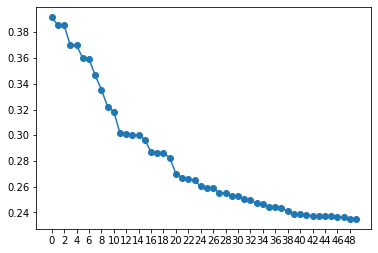

In [144]:
# check indices of points that might be too far away from all other points
mean_dists = mindists
n = 50
plt.plot(sorted(mean_dists)[::-1][:n])
plt.scatter(range(n),sorted(mean_dists)[::-1][:n])
plt.xticks(range(0,n,2))
outls = np.argsort(mean_dists)[::-1][:n]
print(','.join(map(str,outls)))
print(','.join(map(str,nonoutliers[outls])))


In [145]:
nonoutliers[outls][:11] # check idxs of a few most faraway points


array([1012,  271,  279, 1312, 1315, 1001, 1017,  293, 1800,   48,  254])

1604,1621,1606,1632,1603,1617,1608,1643,1629,1626,1644,1618,1620,1622,1600,1640,1637,1625,1611,1776,1791,1614,1639,1633,1610,1630,1612,1634,1615,1648,243,202,1623,1628,1641,1358,1369,1613,1647,318,331,1635,1607,1616,1783,1794,346,316,1609,315,336,1902,1936,1646,1627,1770,1779,1763,1762,1544,1531,603,628,1754,1751,600,619,1636,427,431,1784,1799,335,1771,1780
1604,1621,1606,1632,1603,1617,1608,1643,1629,1626,1644,1618,1620,1622,1600,1640,1637,1625,1611,1776,1791,1614,1639,1633,1610,1630,1612,1634,1615,1648,243,202,1623,1628,1641,1358,1369,1613,1647,318,331,1635,1607,1616,1783,1794,346,316,1609,315,336,1902,1936,1646,1627,1770,1779,1763,1762,1544,1531,603,628,1754,1751,600,619,1636,427,431,1784,1799,335,1771,1780


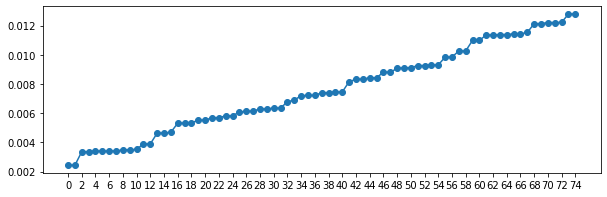

In [146]:
# ... and check for points that might be way too close to one another (nearly-identical)
mean_dists = mindists
n = 75
plt.figure(0,(10,3))
plt.plot(sorted(mean_dists)[:n])
plt.scatter(range(n),sorted(mean_dists)[:n])
plt.xticks(range(0,n,2))
outls = np.argsort(mean_dists)[:n]
print(','.join(map(str,outls)))
print(','.join(map(str,nonoutliers[outls])))

In [147]:
nonoutliers[outls][:1] # check idxs of a few points that are almost identical to discard


array([1604])

In [148]:
# build a short list of potential outliers and remove them from the analysis -- this can greatly improve the visualization

outliers_list = [1012,  271,  279, 1312, 1315, 1001, 1017,  293, 1800,   48,  254, #too far
                1604] #too close?

myX = X[[c for c in range(X.shape[0]) if c not in outliers_list]]
# keep track of original idxs of the actual neurons being used
nonoutliers = np.array([i for i in range(X.shape[0]) if i not in outliers_list])

# compute matrix of squared distances
D2 = pwdists(myX, sqdists=True)

# update N
N = D2.shape[0]

### compute IAN weighted graph

### Iteration 1 done. (2.43 s) - pruned 7 edge(s)
### Iteration 2 done. (0.76 s) - pruned 7 edge(s)
### Iteration 3 done. (1.23 s) - pruned 7 edge(s)
### Iteration 4 done. (0.94 s) - pruned 7 edge(s)
### Iteration 5 done. (1.08 s) - pruned 7 edge(s)
### Iteration 6 done. (1.03 s) - pruned 6 edge(s)
### Iteration 7 done. (0.48 s) - pruned 6 edge(s)
### Iteration 8 done. (0.51 s) - pruned 5 edge(s)
### Iteration 9 done. (0.44 s) - pruned 5 edge(s)
### Iteration 10 done. (0.67 s) - pruned 5 edge(s)
### Iteration 11 done. (0.83 s) - pruned 6 edge(s)
### Iteration 12 done. (1.21 s) - pruned 6 edge(s)
### Iteration 13 done. (1.81 s) - pruned 5 edge(s)
### Iteration 14 done. (0.99 s) - pruned 5 edge(s)
### Iteration 15 done. (0.92 s) - pruned 5 edge(s)
### Iteration 16 done. (0.66 s) - pruned 5 edge(s)
### Iteration 17 done. (0.63 s) - pruned 5 edge(s)
### Iteration 18 done. (0.46 s) - pruned 5 edge(s)
### Iteration 19 done. (0.44 s) - pruned 4 edge(s)
### Iteration 20 done. (0.45 s) - pruned

### Iteration 161 done. (0.43 s) - pruned 1 edge(s)
### Iteration 162 done. (0.42 s) - pruned 1 edge(s)
### Iteration 163 done. (0.42 s) - pruned 1 edge(s)
### Iteration 164 done. (0.42 s) - pruned 21 edge(s)
### Iteration 165 done. (0.41 s) - pruned 1 edge(s)
### Iteration 166 done. (0.40 s) - pruned 1 edge(s)
### Iteration 167 done. (0.42 s) - pruned 1 edge(s)
### Iteration 168 done. (0.41 s) - pruned 1 edge(s)
### Iteration 169 done. (0.42 s) - pruned 1 edge(s)
### Iteration 170 done. (0.40 s) - pruned 1 edge(s)
### Iteration 171 done. (0.40 s) - pruned 1 edge(s)
### Iteration 172 done. (0.40 s) - pruned 1 edge(s)
### Iteration 173 done. (0.41 s) - pruned 1 edge(s)
### Iteration 174 done. (0.41 s) - pruned 1 edge(s)
### Iteration 175 done. (0.41 s) - pruned 1 edge(s)
### Iteration 176 done. (0.44 s) - pruned 1 edge(s)
### Iteration 177 done. (0.42 s) - pruned 1 edge(s)
### Iteration 178 done. (0.40 s) - pruned 1 edge(s)
### Iteration 179 done. (3.76 s) - pruned 3 edge(s)
### Iterati

### Iteration 319 done. (0.37 s) - pruned 1 edge(s)
### Iteration 320 done. (0.38 s) - pruned 1 edge(s)
### Iteration 321 done. (0.38 s) - pruned 1 edge(s)
### Iteration 322 done. (0.40 s) - pruned 1 edge(s)
### Iteration 323 done. (0.38 s) - pruned 1 edge(s)
### Iteration 324 done. (0.39 s) - pruned 1 edge(s)
### Iteration 325 done. (0.37 s) - pruned 1 edge(s)
### Iteration 326 done. (0.38 s) - pruned 1 edge(s)
### Iteration 327 done. (0.36 s) - pruned 1 edge(s)
### Iteration 328 done. (0.38 s) - pruned 23 edge(s)
### Iteration 329 done. (0.37 s) - pruned 1 edge(s)
### Iteration 330 done. (0.35 s) - pruned 1 edge(s)
### Iteration 331 done. (0.38 s) - pruned 1 edge(s)
### Iteration 332 done. (0.37 s) - pruned 1 edge(s)
### Iteration 333 done. (0.36 s) - pruned 1 edge(s)
### Iteration 334 done. (0.35 s) - pruned 1 edge(s)
### Iteration 335 done. (0.34 s) - pruned 1 edge(s)
### Iteration 336 done. (0.36 s) - pruned 1 edge(s)
### Iteration 337 done. (0.35 s) - pruned 1 edge(s)
### Iterati

### Iteration 477 done. (0.34 s) - pruned 1 edge(s)
### Iteration 478 done. (0.49 s) - pruned 13 edge(s)
### Iteration 479 done. (0.55 s) - pruned 1 edge(s)
### Iteration 480 done. (0.56 s) - pruned 1 edge(s)
### Iteration 481 done. (0.77 s) - pruned 1 edge(s)
### Iteration 482 done. (0.64 s) - pruned 1 edge(s)
### Iteration 483 done. (0.34 s) - pruned 1 edge(s)
### Iteration 484 done. (0.36 s) - pruned 1 edge(s)
### Iteration 485 done. (0.35 s) - pruned 12 edge(s)
### Iteration 486 done. (0.34 s) - pruned 1 edge(s)
### Iteration 487 done. (0.38 s) - pruned 1 edge(s)
### Iteration 488 done. (0.37 s) - pruned 1 edge(s)
### Iteration 489 done. (0.33 s) - pruned 1 edge(s)
### Iteration 490 done. (0.34 s) - pruned 1 edge(s)
### Iteration 491 done. (0.35 s) - pruned 1 edge(s)
### Iteration 492 done. (0.34 s) - pruned 1 edge(s)
### Iteration 493 done. (0.34 s) - pruned 1 edge(s)
### Iteration 494 done. (0.37 s) - pruned 1 edge(s)
### Iteration 495 done. (0.52 s) - pruned 1 edge(s)
### Iterat

### Iteration 635 done. (0.34 s) - pruned 1 edge(s)
### Iteration 636 done. (0.34 s) - pruned 1 edge(s)
### Iteration 637 done. (0.35 s) - pruned 1 edge(s)
### Iteration 638 done. (0.35 s) - pruned 1 edge(s)
### Iteration 639 done. (0.34 s) - pruned 1 edge(s)
### Iteration 640 done. (0.56 s) - pruned 1 edge(s)
### Iteration 641 done. (0.80 s) - pruned 1 edge(s)
### Iteration 642 done. (0.56 s) - pruned 1 edge(s)
### Iteration 643 done. (0.65 s) - pruned 1 edge(s)
### Iteration 644 done. (0.56 s) - pruned 1 edge(s)
### Iteration 645 done. (0.33 s) - pruned 1 edge(s)
### Iteration 646 done. (0.76 s) - pruned 1 edge(s)
### Iteration 647 done. (0.49 s) - pruned 1 edge(s)
### Iteration 648 done. (0.33 s) - pruned 1 edge(s)
### Iteration 649 done. (0.80 s) - pruned 1 edge(s)
### Iteration 650 done. (0.77 s) - pruned 1 edge(s)
### Iteration 651 done. (0.59 s) - pruned 1 edge(s)
### Iteration 652 done. (0.33 s) - pruned 1 edge(s)
### Iteration 653 done. (0.34 s) - pruned 1 edge(s)
### Iteratio

### Iteration 793 done. (0.33 s) - pruned 1 edge(s)
### Iteration 794 done. (0.85 s) - pruned 1 edge(s)
### Iteration 795 done. (0.46 s) - pruned 1 edge(s)
### Iteration 796 done. (0.39 s) - pruned 1 edge(s)
### Iteration 797 done. (0.46 s) - pruned 1 edge(s)
### Iteration 798 done. (0.64 s) - pruned 8 edge(s)
### Iteration 799 done. (0.37 s) - pruned 1 edge(s)
### Iteration 800 done. (0.31 s) - pruned 1 edge(s)
### Iteration 801 done. (0.31 s) - pruned 1 edge(s)
### Iteration 802 done. (0.31 s) - pruned 1 edge(s)
### Iteration 803 done. (0.53 s) - pruned 1 edge(s)
### Iteration 804 done. (0.43 s) - pruned 1 edge(s)
### Iteration 805 done. (0.87 s) - pruned 1 edge(s)
### Iteration 806 done. (0.84 s) - pruned 1 edge(s)
### Iteration 807 done. (0.90 s) - pruned 1 edge(s)
### Iteration 808 done. (0.52 s) - pruned 1 edge(s)
### Iteration 809 done. (0.75 s) - pruned 1 edge(s)
### Iteration 810 done. (0.48 s) - pruned 1 edge(s)
### Iteration 811 done. (0.34 s) - pruned 1 edge(s)
### Iteratio

### Iteration 951 done. (0.31 s) - pruned 2 edge(s)
### Iteration 952 done. (0.45 s) - pruned 1 edge(s)
### Iteration 953 done. (0.62 s) - pruned 1 edge(s)
### Iteration 954 done. (0.30 s) - pruned 1 edge(s)
### Iteration 955 done. (0.48 s) - pruned 1 edge(s)
### Iteration 956 done. (0.56 s) - pruned 1 edge(s)
### Iteration 957 done. (0.96 s) - pruned 1 edge(s)
### Iteration 958 done. (0.47 s) - pruned 1 edge(s)
### Iteration 959 done. (0.38 s) - pruned 1 edge(s)
### Iteration 960 done. (0.31 s) - pruned 1 edge(s)
### Iteration 961 done. (0.45 s) - pruned 1 edge(s)
### Iteration 962 done. (0.30 s) - pruned 1 edge(s)
### Iteration 963 done. (0.29 s) - pruned 2 edge(s)
### Iteration 964 done. (0.31 s) - pruned 3 edge(s)
### Iteration 965 done. (0.28 s) - pruned 2 edge(s)
### Iteration 966 done. (0.30 s) - pruned 3 edge(s)
### Iteration 967 done. (0.32 s) - pruned 3 edge(s)
### Iteration 968 done. (0.53 s) - pruned 3 edge(s)
### Iteration 969 done. (0.33 s) - pruned 3 edge(s)
### Iteratio

### Iteration 1107 done. (0.62 s) - pruned 2 edge(s)
### Iteration 1108 done. (0.35 s) - pruned 2 edge(s)
### Iteration 1109 done. (0.37 s) - pruned 2 edge(s)
### Iteration 1110 done. (0.33 s) - pruned 1 edge(s)
### Iteration 1111 done. (0.29 s) - pruned 2 edge(s)
### Iteration 1112 done. (0.37 s) - pruned 2 edge(s)
### Iteration 1113 done. (0.28 s) - pruned 2 edge(s)
### Iteration 1114 done. (0.29 s) - pruned 2 edge(s)
### Iteration 1115 done. (0.54 s) - pruned 2 edge(s)
### Iteration 1116 done. (0.46 s) - pruned 2 edge(s)
### Iteration 1117 done. (0.31 s) - pruned 2 edge(s)
### Iteration 1118 done. (0.30 s) - pruned 2 edge(s)
### Iteration 1119 done. (0.30 s) - pruned 2 edge(s)
### Iteration 1120 done. (0.29 s) - pruned 1 edge(s)
### Iteration 1121 done. (0.49 s) - pruned 1 edge(s)
### Iteration 1122 done. (0.53 s) - pruned 1 edge(s)
### Iteration 1123 done. (0.34 s) - pruned 1 edge(s)
### Iteration 1124 done. (0.31 s) - pruned 1 edge(s)
### Iteration 1125 done. (0.45 s) - pruned 1 e

### Iteration 1262 done. (0.29 s) - pruned 1 edge(s)
### Iteration 1263 done. (0.27 s) - pruned 1 edge(s)
### Iteration 1264 done. (0.28 s) - pruned 1 edge(s)
### Iteration 1265 done. (0.33 s) - pruned 1 edge(s)
### Iteration 1266 done. (0.29 s) - pruned 1 edge(s)
### Iteration 1267 done. (0.36 s) - pruned 1 edge(s)
### Iteration 1268 done. (0.29 s) - pruned 1 edge(s)
### Iteration 1269 done. (0.29 s) - pruned 1 edge(s)
### Iteration 1270 done. (0.30 s) - pruned 1 edge(s)
### Iteration 1271 done. (0.31 s) - pruned 1 edge(s)
### Iteration 1272 done. (0.29 s) - pruned 1 edge(s)
### Iteration 1273 done. (0.31 s) - pruned 1 edge(s)
### Iteration 1274 done. (0.32 s) - pruned 1 edge(s)
### Iteration 1275 done. (0.30 s) - pruned 1 edge(s)
### Iteration 1276 done. (0.29 s) - pruned 1 edge(s)
### Iteration 1277 done. (0.30 s) - pruned 1 edge(s)
### Iteration 1278 done. (0.30 s) - pruned 1 edge(s)
### Iteration 1279 done. (0.30 s) - pruned 1 edge(s)
### Iteration 1280 done. (0.31 s) - pruned 1 e

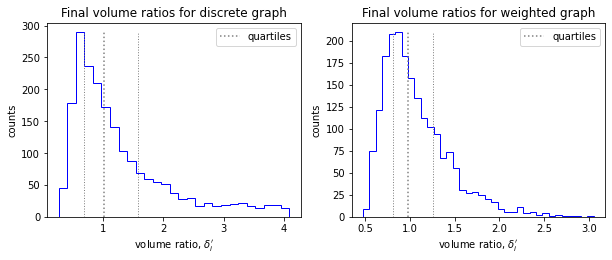

In [23]:
# solver = 'GUROBI' #using a commercial optimization package is highly recommended for faster kernel convergence.
# A free academic license can be obtained at https://www.gurobi.com/academia/academic-program-and-licenses/

# use None if you don't have a preferred solver, or pick from the list of solvers from cvxpy: 
# https://www.cvxpy.org/tutorial/advanced/index.html#choosing-a-solver
# This is usually fine for moderate sized datasets.
solver = None 

G, wG, optScales, disc_pts = IAN('exact-precomputed-sq', D2, solver=solver)

# Optional: instead of picking a single decomposition result, can compute separate graphs for each initialization and
# average them together to combine all results into a single weighted graph.

### Iteration 1 done. (2.21 s) - pruned 7 edge(s)
### Iteration 2 done. (0.42 s) - pruned 7 edge(s)
### Iteration 3 done. (0.50 s) - pruned 7 edge(s)
### Iteration 4 done. (0.43 s) - pruned 7 edge(s)
### Iteration 5 done. (0.41 s) - pruned 7 edge(s)
### Iteration 6 done. (0.42 s) - pruned 6 edge(s)
### Iteration 7 done. (0.40 s) - pruned 6 edge(s)
### Iteration 8 done. (0.37 s) - pruned 5 edge(s)
### Iteration 9 done. (0.42 s) - pruned 5 edge(s)
### Iteration 10 done. (0.81 s) - pruned 5 edge(s)
### Iteration 11 done. (0.54 s) - pruned 6 edge(s)
### Iteration 12 done. (0.58 s) - pruned 6 edge(s)
### Iteration 13 done. (0.65 s) - pruned 5 edge(s)
### Iteration 14 done. (0.43 s) - pruned 5 edge(s)
### Iteration 15 done. (0.45 s) - pruned 5 edge(s)
### Iteration 16 done. (0.41 s) - pruned 5 edge(s)
### Iteration 17 done. (0.82 s) - pruned 5 edge(s)
### Iteration 18 done. (0.39 s) - pruned 5 edge(s)
### Iteration 19 done. (0.57 s) - pruned 4 edge(s)
### Iteration 20 done. (0.76 s) - pruned

### Iteration 161 done. (0.34 s) - pruned 1 edge(s)
### Iteration 162 done. (0.33 s) - pruned 1 edge(s)
### Iteration 163 done. (0.33 s) - pruned 1 edge(s)
### Iteration 164 done. (0.34 s) - pruned 21 edge(s)
### Iteration 165 done. (0.32 s) - pruned 1 edge(s)
### Iteration 166 done. (0.37 s) - pruned 1 edge(s)
### Iteration 167 done. (0.34 s) - pruned 1 edge(s)
### Iteration 168 done. (0.32 s) - pruned 1 edge(s)
### Iteration 169 done. (0.33 s) - pruned 1 edge(s)
### Iteration 170 done. (0.35 s) - pruned 1 edge(s)
### Iteration 171 done. (0.32 s) - pruned 1 edge(s)
### Iteration 172 done. (0.34 s) - pruned 1 edge(s)
### Iteration 173 done. (0.32 s) - pruned 1 edge(s)
### Iteration 174 done. (0.34 s) - pruned 1 edge(s)
### Iteration 175 done. (0.34 s) - pruned 1 edge(s)
### Iteration 176 done. (0.33 s) - pruned 1 edge(s)
### Iteration 177 done. (0.34 s) - pruned 1 edge(s)
### Iteration 178 done. (0.34 s) - pruned 1 edge(s)
### Iteration 179 done. (3.03 s) - pruned 3 edge(s)
### Iterati

### Iteration 319 done. (0.30 s) - pruned 1 edge(s)
### Iteration 320 done. (0.30 s) - pruned 1 edge(s)
### Iteration 321 done. (0.30 s) - pruned 1 edge(s)
### Iteration 322 done. (0.31 s) - pruned 1 edge(s)
### Iteration 323 done. (0.32 s) - pruned 1 edge(s)
### Iteration 324 done. (0.31 s) - pruned 1 edge(s)
### Iteration 325 done. (0.31 s) - pruned 1 edge(s)
### Iteration 326 done. (0.31 s) - pruned 1 edge(s)
### Iteration 327 done. (0.31 s) - pruned 1 edge(s)
### Iteration 328 done. (0.30 s) - pruned 23 edge(s)
### Iteration 329 done. (0.29 s) - pruned 1 edge(s)
### Iteration 330 done. (0.31 s) - pruned 1 edge(s)
### Iteration 331 done. (0.30 s) - pruned 1 edge(s)
### Iteration 332 done. (0.32 s) - pruned 1 edge(s)
### Iteration 333 done. (0.29 s) - pruned 1 edge(s)
### Iteration 334 done. (0.31 s) - pruned 1 edge(s)
### Iteration 335 done. (0.29 s) - pruned 1 edge(s)
### Iteration 336 done. (0.31 s) - pruned 1 edge(s)
### Iteration 337 done. (0.29 s) - pruned 1 edge(s)
### Iterati

### Iteration 477 done. (0.30 s) - pruned 1 edge(s)
### Iteration 478 done. (0.28 s) - pruned 13 edge(s)
### Iteration 479 done. (0.30 s) - pruned 1 edge(s)
### Iteration 480 done. (0.28 s) - pruned 1 edge(s)
### Iteration 481 done. (0.28 s) - pruned 1 edge(s)
### Iteration 482 done. (0.28 s) - pruned 1 edge(s)
### Iteration 483 done. (0.28 s) - pruned 1 edge(s)
### Iteration 484 done. (0.29 s) - pruned 1 edge(s)
### Iteration 485 done. (0.27 s) - pruned 12 edge(s)
### Iteration 486 done. (0.29 s) - pruned 1 edge(s)
### Iteration 487 done. (0.26 s) - pruned 1 edge(s)
### Iteration 488 done. (0.28 s) - pruned 1 edge(s)
### Iteration 489 done. (0.27 s) - pruned 1 edge(s)
### Iteration 490 done. (0.30 s) - pruned 1 edge(s)
### Iteration 491 done. (0.27 s) - pruned 1 edge(s)
### Iteration 492 done. (0.28 s) - pruned 1 edge(s)
### Iteration 493 done. (0.26 s) - pruned 1 edge(s)
### Iteration 494 done. (0.29 s) - pruned 1 edge(s)
### Iteration 495 done. (0.27 s) - pruned 1 edge(s)
### Iterat

### Iteration 635 done. (0.26 s) - pruned 1 edge(s)
### Iteration 636 done. (0.28 s) - pruned 1 edge(s)
### Iteration 637 done. (0.27 s) - pruned 1 edge(s)
### Iteration 638 done. (0.28 s) - pruned 1 edge(s)
### Iteration 639 done. (0.28 s) - pruned 1 edge(s)
### Iteration 640 done. (0.30 s) - pruned 1 edge(s)
### Iteration 641 done. (0.27 s) - pruned 1 edge(s)
### Iteration 642 done. (0.28 s) - pruned 1 edge(s)
### Iteration 643 done. (0.26 s) - pruned 1 edge(s)
### Iteration 644 done. (0.29 s) - pruned 1 edge(s)
### Iteration 645 done. (0.27 s) - pruned 1 edge(s)
### Iteration 646 done. (0.28 s) - pruned 1 edge(s)
### Iteration 647 done. (0.28 s) - pruned 1 edge(s)
### Iteration 648 done. (0.28 s) - pruned 1 edge(s)
### Iteration 649 done. (0.27 s) - pruned 1 edge(s)
### Iteration 650 done. (0.27 s) - pruned 1 edge(s)
### Iteration 651 done. (0.27 s) - pruned 1 edge(s)
### Iteration 652 done. (0.30 s) - pruned 1 edge(s)
### Iteration 653 done. (0.27 s) - pruned 1 edge(s)
### Iteratio

### Iteration 793 done. (0.27 s) - pruned 1 edge(s)
### Iteration 794 done. (0.26 s) - pruned 1 edge(s)
### Iteration 795 done. (0.27 s) - pruned 1 edge(s)
### Iteration 796 done. (0.26 s) - pruned 1 edge(s)
### Iteration 797 done. (0.26 s) - pruned 1 edge(s)
### Iteration 798 done. (0.27 s) - pruned 8 edge(s)
### Iteration 799 done. (0.25 s) - pruned 1 edge(s)
### Iteration 800 done. (0.26 s) - pruned 1 edge(s)
### Iteration 801 done. (0.27 s) - pruned 1 edge(s)
### Iteration 802 done. (0.26 s) - pruned 1 edge(s)
### Iteration 803 done. (0.28 s) - pruned 1 edge(s)
### Iteration 804 done. (0.27 s) - pruned 1 edge(s)
### Iteration 805 done. (0.26 s) - pruned 1 edge(s)
### Iteration 806 done. (0.26 s) - pruned 1 edge(s)
### Iteration 807 done. (0.27 s) - pruned 1 edge(s)
### Iteration 808 done. (0.26 s) - pruned 1 edge(s)
### Iteration 809 done. (0.26 s) - pruned 1 edge(s)
### Iteration 810 done. (0.25 s) - pruned 1 edge(s)
### Iteration 811 done. (0.25 s) - pruned 1 edge(s)
### Iteratio

### Iteration 951 done. (0.26 s) - pruned 2 edge(s)
### Iteration 952 done. (0.24 s) - pruned 1 edge(s)
### Iteration 953 done. (0.26 s) - pruned 1 edge(s)
### Iteration 954 done. (0.24 s) - pruned 1 edge(s)
### Iteration 955 done. (0.29 s) - pruned 1 edge(s)
### Iteration 956 done. (0.24 s) - pruned 1 edge(s)
### Iteration 957 done. (0.25 s) - pruned 1 edge(s)
### Iteration 958 done. (0.25 s) - pruned 1 edge(s)
### Iteration 959 done. (0.25 s) - pruned 1 edge(s)
### Iteration 960 done. (0.24 s) - pruned 1 edge(s)
### Iteration 961 done. (0.28 s) - pruned 1 edge(s)
### Iteration 962 done. (0.25 s) - pruned 1 edge(s)
### Iteration 963 done. (0.26 s) - pruned 2 edge(s)
### Iteration 964 done. (0.24 s) - pruned 3 edge(s)
### Iteration 965 done. (0.27 s) - pruned 2 edge(s)
### Iteration 966 done. (0.24 s) - pruned 3 edge(s)
### Iteration 967 done. (0.26 s) - pruned 3 edge(s)
### Iteration 968 done. (0.23 s) - pruned 3 edge(s)
### Iteration 969 done. (0.24 s) - pruned 3 edge(s)
### Iteratio

### Iteration 1107 done. (0.23 s) - pruned 2 edge(s)
### Iteration 1108 done. (0.26 s) - pruned 2 edge(s)
### Iteration 1109 done. (0.23 s) - pruned 2 edge(s)
### Iteration 1110 done. (0.27 s) - pruned 1 edge(s)
### Iteration 1111 done. (0.26 s) - pruned 2 edge(s)
### Iteration 1112 done. (0.25 s) - pruned 2 edge(s)
### Iteration 1113 done. (0.22 s) - pruned 2 edge(s)
### Iteration 1114 done. (0.24 s) - pruned 2 edge(s)
### Iteration 1115 done. (0.24 s) - pruned 2 edge(s)
### Iteration 1116 done. (0.23 s) - pruned 2 edge(s)
### Iteration 1117 done. (0.25 s) - pruned 2 edge(s)
### Iteration 1118 done. (0.24 s) - pruned 2 edge(s)
### Iteration 1119 done. (0.27 s) - pruned 2 edge(s)
### Iteration 1120 done. (0.23 s) - pruned 1 edge(s)
### Iteration 1121 done. (0.26 s) - pruned 1 edge(s)
### Iteration 1122 done. (0.23 s) - pruned 1 edge(s)
### Iteration 1123 done. (0.25 s) - pruned 1 edge(s)
### Iteration 1124 done. (0.23 s) - pruned 1 edge(s)
### Iteration 1125 done. (0.22 s) - pruned 1 e

### Iteration 1262 done. (0.23 s) - pruned 1 edge(s)
### Iteration 1263 done. (0.22 s) - pruned 1 edge(s)
### Iteration 1264 done. (0.25 s) - pruned 1 edge(s)
### Iteration 1265 done. (0.22 s) - pruned 1 edge(s)
### Iteration 1266 done. (0.25 s) - pruned 1 edge(s)
### Iteration 1267 done. (0.21 s) - pruned 1 edge(s)
### Iteration 1268 done. (0.23 s) - pruned 1 edge(s)
### Iteration 1269 done. (0.23 s) - pruned 1 edge(s)
### Iteration 1270 done. (0.22 s) - pruned 1 edge(s)
### Iteration 1271 done. (0.23 s) - pruned 1 edge(s)
### Iteration 1272 done. (0.21 s) - pruned 1 edge(s)
### Iteration 1273 done. (0.23 s) - pruned 1 edge(s)
### Iteration 1274 done. (0.23 s) - pruned 1 edge(s)
### Iteration 1275 done. (0.24 s) - pruned 1 edge(s)
### Iteration 1276 done. (0.23 s) - pruned 1 edge(s)
### Iteration 1277 done. (0.23 s) - pruned 1 edge(s)
### Iteration 1278 done. (0.25 s) - pruned 1 edge(s)
### Iteration 1279 done. (0.24 s) - pruned 1 edge(s)
### Iteration 1280 done. (0.25 s) - pruned 1 e

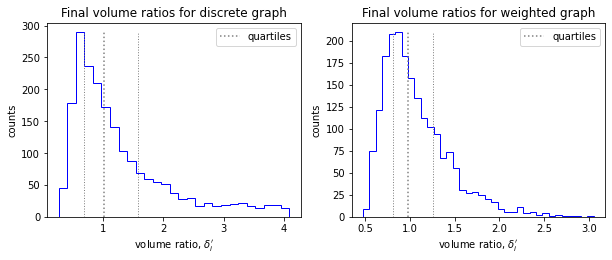

In [149]:
# solver = 'GUROBI' #using a commercial optimization package is highly recommended for faster kernel convergence.
# A free academic license can be obtained at https://www.gurobi.com/academia/academic-program-and-licenses/

# use None if you don't have a preferred solver, or pick from the list of solvers from cvxpy: 
# https://www.cvxpy.org/tutorial/advanced/index.html#choosing-a-solver
# This is usually fine for moderate sized datasets.
solver = None 

G, wG, optScales, disc_pts = IAN('exact-precomputed-sq', D2, solver=solver)

# Optional: instead of picking a single decomposition result, can compute separate graphs for each initialization and
# average them together to combine all results into a single weighted graph.

In [150]:
# Note: if any points were disconnected (`disc_pts`) during the IAN optimization, need to remove them from the
# graphs and update the list of outliers and nonoutliers

new_outliers = [disc_pts[di][0] for di in range(len(disc_pts))]
nonout_mask = np.ones(optScales.size)
nonout_mask[new_outliers] = 0

if new_outliers:

    wG = getSparseMultiScaleK(D2[nonout_mask][:,nonout_mask],optScales[nonout_mask])
    G = G[nonout_mask][:,nonout_mask]
    
    #update list of outliers and nonoutliers
    outliers += new_outliers
    nonoutliers = np.array([i for i in range(X.shape[0]) if i not in outliers])


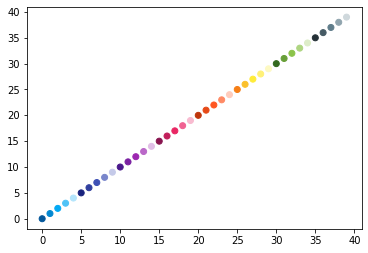

In [151]:
# nice colors to reasonably differentiate between up to 40 fmaps
palstr = np.array(['#03579b', '#0488d1', '#03a9f4', '#4fc3f7', '#b3e5fc', '#19237e',
          '#303f9f', '#3f51b5', '#7986cb', '#c5cae9', '#4a198c', '#7b21a2', '#9c27b0', '#ba68c8', '#e1bee7', '#88144f', '#c21f5b',
          '#e92663', '#f06292', '#f8bbd0', '#bf360c', '#e64a18', '#ff5722', '#ff8a65', '#ffccbc', '#f67f17', '#fbc02c', '#ffec3a',
          '#fff177', '#fdf9c3', '#33691d', '#689f38', '#8bc34a', '#aed581', '#ddedc8',
         '#253137', '#455a64', '#607d8b', '#90a4ae', '#cfd8dc',])

plt.scatter(range(len(palstr)),range(len(palstr)),c=palstr)



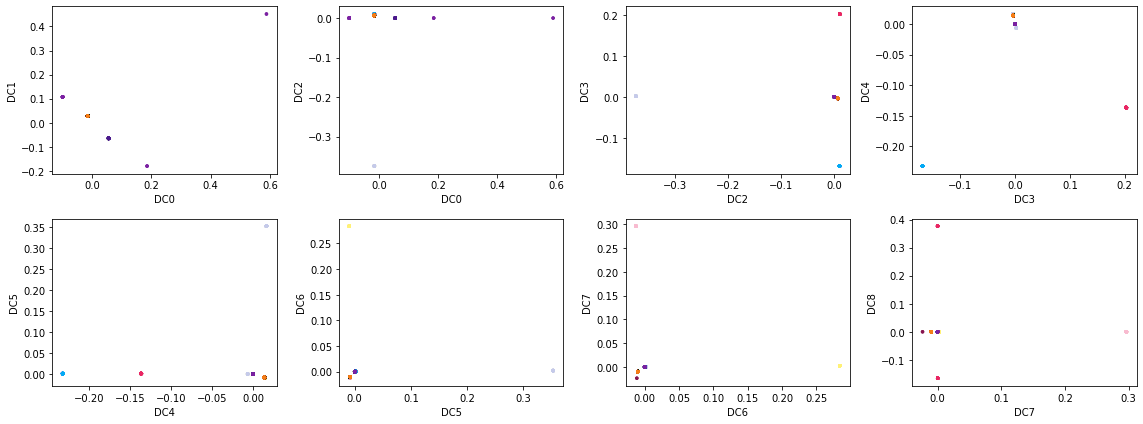

In [152]:
diffmap_y, diffmap_evals = diffusionMapSparseK(wG, 20, 1, t=1)

c = neurons_used[nonoutliers,1] # labels for the different feature maps
ulbls, labels = np.unique(c,return_inverse=True)
cluster_colors = [palstr[li] for li in labels]

# flip thru diff coords to see the multiple clusters (usually strongly associated with a specific feature map)
DCs = [(0,1), (0,2), (2,3), (3,4),
      (4,5), (5,6), (6,7), (7,8)]

f, axes = subps(2, len(PCs)//2)

for ax, (dci, dcj) in zip(axes.ravel(), PCs):
    ax.scatter(*diffmap_y[:,[dci, dcj]].T,c=cluster_colors,s=6)
    ax.set(xlabel=f'DC{dci}', ylabel=f'DC{dcj}')
f.tight_layout()
plt.show()

In [ ]:
# Improving visualization of the diffusion map result: using metric MDS to find a low-dim projection that
#   shows all the clusters together
ndcs = nPCs
# the code below implements MDS using the kernel PCA module from scikit-learn
from sklearn.decomposition import KernelPCA # 
embedding_D2 = squareform(pdist(diffmap_y[:,:ndcs],'sqeuclidean'))
G = -.5 * embedding_D2
n_components = 10
kernel_pca_ = KernelPCA(
    n_components=n_components,
    kernel="precomputed",
)
embedding_ = kernel_pca_.fit_transform(G) #this method includes the centering of G

In [19]:
# Nicer 3d scatter plot using plotly -- easier zooming, rotating, etc.

import plotly.graph_objects as go

# embedding to be plotted
Y = embedding_

# pick 3 coords to plot
dcs = [0,1,3]


fig = go.Figure()
traces = []


#color palette
mypal = palstr

colors = neurons_used[nonoutliers,1][delmask]
fmapis = np.unique(colors)

while len(mypal) < len(fmapis):
    mypal = np.r_[mypal,mypal]

mypal = mypal[np.arange(0,len(mypal),len(mypal)//len(fmapis))]

hovertext = np.array(list(map(str,nonoutliers)))[delmask]
hovertext = np.array(list(map(str,colors)))
hovertext = np.array(list(map(lambda p: f'{p[0]}_{p[1]}', zip(neurons_used[nonoutliers,0][delmask],neurons_used[nonoutliers,1][delmask]))))


for fi,fmapi in enumerate(fmapis):
    color_mask = colors==fmapi
    traces.append(go.Scatter3d(
        x=Y[color_mask,dcs[0]],
        y=Y[color_mask,dcs[1]],
        z=Y[color_mask,dcs[2]],
        mode='markers',
        name='',
        hoverinfo='text',
        hovertext=hovertext[color_mask],
        marker=dict(
            size=4,
            color=mypal[fi],#'blue',
            opacity=1,
            #colorscale=colorscale,
            #showscale= True,
        )))

for trace in traces:
    fig.add_trace(trace)
radius = .5
dcranges = [(-radius,radius)]*3
dcranges = [None]*3
axis_visible = True
showDClbl = True
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,
                    paper_bgcolor="#f3f3f3",
                    scene={"aspectmode": "cube", 


                    "xaxis": dict(
                        title=f'dc{dcs[0]}' if showDClbl else '',visible= axis_visible, showticklabels= False, range=dcranges[0]),
                    "yaxis": dict(
                        title=f'dc{dcs[1]}' if showDClbl else '',visible= axis_visible, showticklabels= False, range=dcranges[1]),
                    "zaxis": dict(
                        title=f'dc{dcs[2]}' if showDClbl else '',visible= axis_visible, showticklabels= False, range=dcranges[2])},)
fig.show()

### HDBSCAN

In [ ]:
# Run HDBSCAN to estimate number of cluster present in the embedded data


# need to pick how many diff coords to consider. to standardize this choice across datasets, using nPCs define above
ndcs = nPCs 
embedding_D2 = squareform(pdist(diffmap_y[:,:ndcs],'sqeuclidean'))
N = embedding_D2.shape[0]
D1 = np.sqrt(embedding_D2)

# compute "core distances" using the IAN discrete graph G (instead of setting an arbitrary number of nbrs, k, to all points)
nbrs_idxs = np.split(G.indices, G.indptr)[1:-1]
core_dists = np.array([max(D1[xi,nbrs_idxs[xi]]) for xi in range(N)])

### Alternative: setting k to the mean degree in G
# A = G.toarray()
# mean_deg = int(round(A.sum(1).mean()))
# core_dists = np.array([max(sorted(D1[xi])[:mean_deg]) for xi in range(N)])

# compute "mutual reachability" from core distances
mutreach = D1.copy()
for xi in range(N):
    mutreach[xi] = np.max([core_dists,core_dists[xi]*np.ones(N), D1[xi]],axis=0)
np.fill_diagonal(mutreach,0)


# Compute the dendrogram + condensed tree
from scipy.cluster.hierarchy import linkage,leaves_list,optimal_leaf_ordering,dendrogram
flat_dist_mat = squareform(mutreach)
Z = linkage(flat_dist_mat, method='single')
leaves = leaves_list(optimal_leaf_ordering(Z, flat_dist_mat))

from hdbscan.hdbscan_ import _tree_to_labels
cluster_labels, probabilities, stabilities, condensed_tree, single_linkage_tree = _tree_to_labels(None,Z,
                                                                                          min_cluster_size=10)
from hdbscan.plots import CondensedTree
cond_tree = CondensedTree(condensed_tree)
cond_tree.plot(select_clusters=True)

np.unique(cluster_labels).size # estimated number of components